In [76]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | binary status if tree has died one year after fire event
| YrFireName                  | fire names                             
| Times_burned                | number of burns tree endured                                  
| Species                     | species of collected sample                                                    
| Genus_species               | genus and species of collected sample                                      
| DBH_cm                      | diameter at breast height
| HT_m                        | height of tree in meters
| CR_pre                      | crown ratio pre-fire
| CR_post                     | crown ratio post-fire

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [41]:
# Load the dataset
trees_dat = pd.read_csv('FTM_trees.csv')
trees_dat.head()

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_57927/340983081.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('FTM_trees.csv')


,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,...,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
0,2006 - Tripod,2TREE,Prichard,1,NaN,188,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
1,2006 - Tripod,2TREE,Prichard,1,NaN,74,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
2,2006 - Tripod,2TREE,Prichard,1,NaN,193,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
3,2006 - Tripod,2TREE,Prichard,1,NaN,126,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
4,2006 - Tripod,2TREE,Prichard,1,NaN,113,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN


In [42]:
# Select columns
trees_dat = trees_dat[["YrFireName", "Times_burned", "Species", "yr1status",
                       "Genus_species", "DBH_cm", "HT_m", "CR_pre", "CR_post"]]
# Drop rows with missing values
trees_dat = trees_dat.dropna().reset_index(drop=True)

trees_dat

,YrFireName,Times_burned,Species,yr1status,Genus_species,DBH_cm,HT_m,CR_pre,CR_post
0,2003 - Griff,1,ABAM,0.0,Abies_amabilis,71.374,41.76,0.84,0.74
1,2003 - Griff,1,ABAM,0.0,Abies_amabilis,23.622,12.80,0.60,0.57
2,2003 - Griff,1,ABAM,0.0,Abies_amabilis,46.228,34.75,0.75,0.59
3,2003 - Griff,1,ABAM,0.0,Abies_amabilis,21.082,23.16,0.38,0.38
4,2003 - Griff,1,ABAM,0.0,Abies_amabilis,24.384,26.21,0.42,0.42
...,...,...,...,...,...,...,...,...,...
36504,2003 - B and B,1,TSME,0.0,Tsuga_mertensiana,32.512,15.54,0.90,0.90
36505,2003 - B and B,1,TSME,0.0,Tsuga_mertensiana,24.892,14.63,0.81,0.81
36506,2003 - B and B,1,TSME,0.0,Tsuga_mertensiana,32.258,16.46,0.85,0.63
36507,2003 - B and B,1,TSME,0.0,Tsuga_mertensiana,31.750,18.59,0.87,0.80


In [43]:
print(f"There are {trees_dat.shape[0]} rows.")

There are 36509 rows.


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [44]:
# Check the data types
trees_dat.dtypes

YrFireName        object
Times_burned       int64
Species           object
yr1status        float64
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object

In [45]:
# Convert the categorical variables to integers
trees_dat["YrFireName"] = trees_dat["YrFireName"].astype("category").cat.codes
trees_dat["Species"]= trees_dat["Species"].astype("category").cat.codes
trees_dat["Genus_species"] = trees_dat["Genus_species"].astype("category").cat.codes

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [46]:
#Specify feature names 
feature_names = ["YrFireName",
    "Times_burned",
    "Species",
    "Genus_species",
    "DBH_cm",
    "HT_m",
    "CR_pre",
    "CR_post"]


In [47]:
# Select features and target
X = trees_dat[feature_names]
y = trees_dat["yr1status"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [49]:
# Verify the training and testing set size
print(f"Training set observations: {len(X_train)}", )
print(f"Testing set observations: {len(X_test)}",)

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [50]:
# Train logistic regression
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

print(f"Training Accuracy: ", accuracy_score(y_train, log_model.predict(X_train_scaled)))

Training Accuracy:  0.945061825011739


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

In [66]:
# Print evaluation metrics
y_test_pred_log = log_model.predict(X_test_scaled)

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_log)}")


print(classification_report(y_test, y_test_pred_log, target_names=["Dead", "Alive"]))

# Print classification report
confusion_matrix_log = confusion_matrix(y_test, y_test_pred_log)
TN = confusion_matrix_log[1,1]
TP = confusion_matrix_log[0,0]
FP = confusion_matrix_log[0,1]
FN = confusion_matrix_log[1,0]

sensitivity = TP / (TP + FN) 
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"True Positives (True Alive): {TP}")
print(f"False Positives (False Alive): {FP}")
print(f"True Negatives (True Deaths): {TN}")
print(f"False Negatives (False Deaths): {FN}")


Accuracy: 0.9401990322286131
              precision    recall  f1-score   support

        Dead       0.96      0.98      0.97     10033
       Alive       0.70      0.50      0.58       920

    accuracy                           0.94     10953
   macro avg       0.83      0.74      0.78     10953
weighted avg       0.93      0.94      0.94     10953

Sensitivity: 0.955331132258691
Specificity: 0.7022900763358778
True Positives (True Alive): 9838
False Positives (False Alive): 195
True Negatives (True Deaths): 460
False Negatives (False Deaths): 460


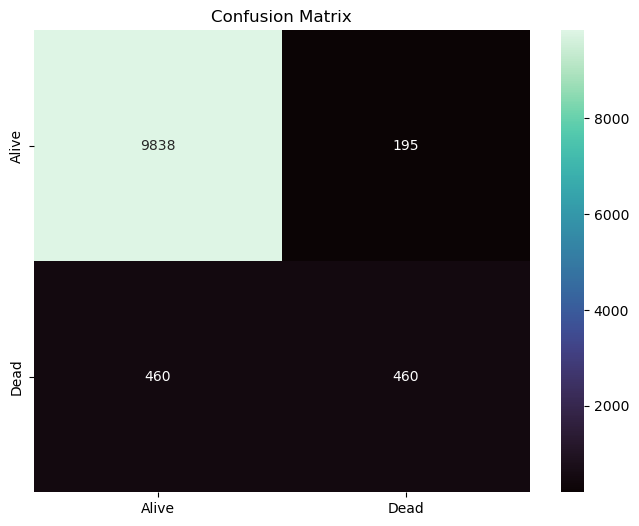

In [71]:
#Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_log, annot=True, fmt="d", cmap='mako',
            xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

It seemingly performs well with an accuracy of 94%. But, he model performs much better on trees that survived. Its sensitivity (True Positive = 95%) yield much better results than its specificity (True Negative = 70%). Yes there is class imbalance, which often leads to a bias in the minority class, which is evident in our specificity. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

If the model were to always predict the majority class, I belive the overall model would not change much. Since there is bias in our minority class, it is not properly classifying dead trees, but alive trees are classified accurately, so our alive trees will likely be modeled well regardless. 

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [53]:
# Dummy Classifier model
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train_scaled, y_train)

# Predict dummy classifier model on training and testing set
X_train_pred_dummy = dummy_classifier.predict(X_train_scaled)
y_test_pred_dummy = dummy_classifier.predict(X_test_scaled)

# Confusion matrix for dummy classifier
confusion_matrix_dummy = confusion_matrix(y_test, y_test_pred_dummy)
TN = confusion_matrix_dummy[1,1]
TP = confusion_matrix_dummy[0,0]
FP = confusion_matrix_dummy[0,1]
FN = confusion_matrix_dummy[1,0]

sensitivity = TP / (TP + FN) 
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"True Positives (True Alive): {TP}")
print(f"False Positives (False Alive): {FP}")
print(f"True Negatives (True Deaths): {TN}")
print(f"False Negatives (False Deaths): {FN}")


Sensitivity: 0.9160047475577467
Specificity: nan
True Positives (True Alive): 10033
False Positives (False Alive): 0
True Negatives (True Deaths): 0
False Negatives (False Deaths): 920


/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_57927/1024325239.py:17: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


In [67]:
...

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {accuracy_score(y_test, y_test_pred_dummy)}")
print(classification_report(y_test, y_test_pred_dummy, target_names=["Dead", "Alive"]))

Dummy Accuracy: 0.9160047475577467
              precision    recall  f1-score   support

        Dead       0.92      1.00      0.96     10033
       Alive       0.00      0.00      0.00       920

    accuracy                           0.92     10953
   macro avg       0.46      0.50      0.48     10953
weighted avg       0.84      0.92      0.88     10953



/Users/ianmorris/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ianmorris/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ianmorris/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_


Dummy Confusion Matrix:


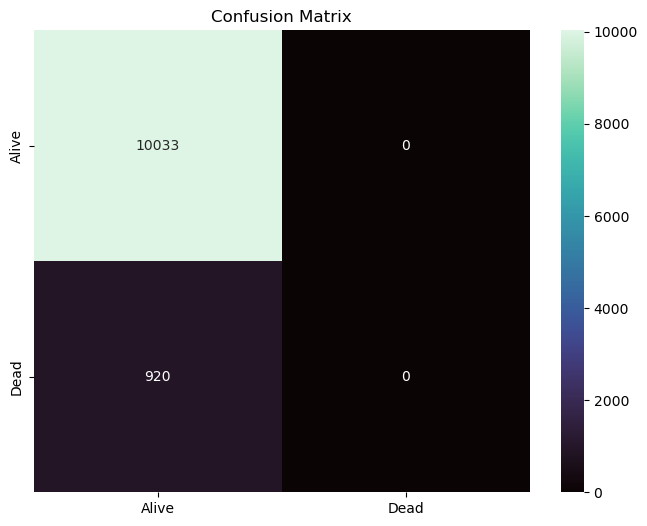

In [72]:
print("\nDummy Confusion Matrix:")

#Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_dummy, annot=True, fmt="d", cmap='mako',
            xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [83]:
# Logistic classifier AUC
print(f"Logistic AUC: {roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])}")

Logistic AUC: 0.9180671176422154


In [85]:
# Dummy classifier AUC
print(f"Logistic AUC: {roc_auc_score(y_test, dummy_classifier.predict_proba(X_test_scaled)[:, 1])}")

Logistic AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

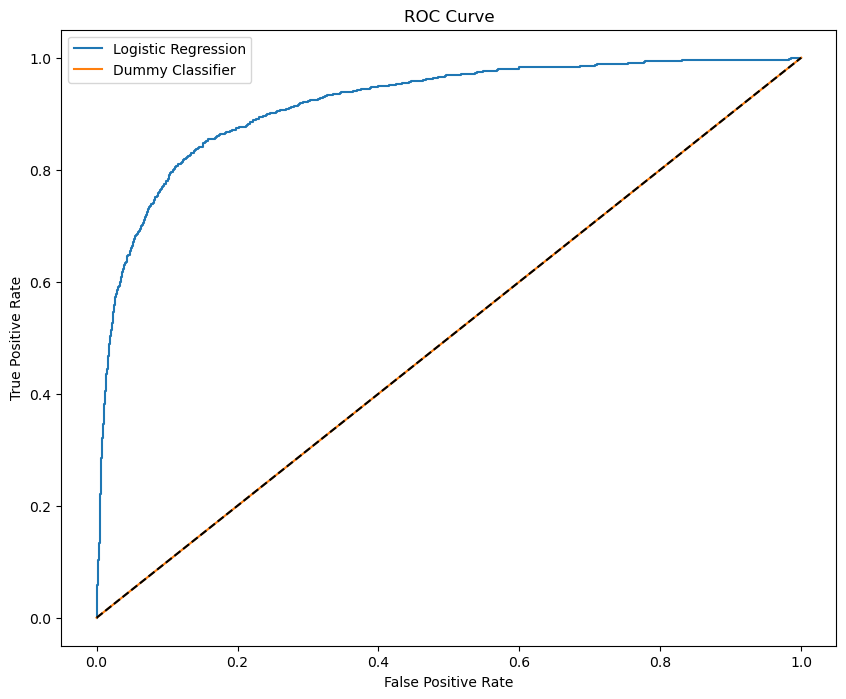

In [86]:
# Plot ROC curve
fpr_log, tpr_log, _ = roc_curve(y_test, log_model.predict_proba(X_test_scaled)[:, 1])
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy_classifier.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_dummy, tpr_dummy, label="Dummy Classifier")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The two models are drastically different in AUC. This shows that though the accracy of their predictions are quite similar, the AUC are not. This shows that we cannot evaluate classifiers based on their accuracy, rather we should look at the model wholistically, including ROC and AUC in addition to accuracy.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [90]:
coefficients = log_model.coef_[0]
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": coefficients}).sort_values("Importance", ascending=False)

# Print the sorted feature importance
print(importance_df)

         Feature  Importance
2        Species    0.541509
4         DBH_cm    0.421324
6         CR_pre    0.123414
1   Times_burned    0.000000
3  Genus_species   -0.067867
0     YrFireName   -0.660497
5           HT_m   -1.165414
7        CR_post   -2.494974


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The most important features are CR_post and HT_m, or crown ratio post fire and height (m), respectivly. Forest managers may see this and prioritize taller, more developed trees species. By ensuring these species are nutured to full growth, we will likely see 